In [1]:
# code base is from below
# https://github.com/keras-team/keras-io/blob/cbda610b5a73b517aa750e1ff14d7c7a70aae91e/examples/vision/ipynb/retinanet.ipynb

In [2]:
# !pip list | grep tensorflow
# !pip uninstall tensorflow-gpu -y
# !pip install tensorflow-gpu
# !pwd

In [3]:
import os
import re
import zipfile
import time

import numpy as np
import tensorflow as tf
from tensorflow import keras
# import keras.backend as kb

import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import cv2

import sys
sys.path.append('../')
from encode import LabelEncoder
from model import *
from losses import RetinaNetLoss

from feed import train_data_loader, val_data_loader
from inference import DecodePredictions
from box_utils import visualize_detections
from preprocess import resize_and_pad_image, paps_process, transforms, switch_image, train_transforms, val_transforms

In [4]:
print(tf.__version__)
# tf.debugging.set_log_device_placement(True)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('memory allow growth')
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)
#     tensorflow gpu 2.5.0 version에서 gpu 인식 실패, 2.4.0으로 해야 된다.
print(tf.test.is_gpu_available())
tf.config.list_physical_devices('GPU')
# tf.enable_eager_execution()

2.4.1
memory allow growth
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
paps_data_path = "/home/Dataset/Papsmear/original/"
labels_info = np.load('../data/labels_info.npy', allow_pickle=True, encoding='latin1').item()
# labels_info['SS/06/20200623_103236.jpg']
partition = np.load('../data/partition.npy', allow_pickle=True, encoding='latin1').item()
print(len(labels_info))
# partition['test']
len(partition['train'])

18690


13490

In [6]:
def paps_train_generator():
    for path in partition['train']:
        image = cv2.imread(paps_data_path + path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = switch_image(image)
        bbox = labels_info[path]
        transformed = train_transforms(image=image, bboxes=bbox)
        image = transformed['image']
        bbox = np.array(transformed['bboxes'])
#         print(bbox.shape[0])
        if bbox.shape[0] == 0 :
#             print('no bounding box')
            label = [1.0]
            bbox = np.array([[0.,0.,1.,1.]])
        else :
            label = [1.0]*bbox.shape[0]
            bbox = bbox[:,:4]
#         bbox[:,4] = 1
        yield image, bbox, label
        
def paps_val_generator():
    for path in partition['test']:
        image = cv2.imread(paps_data_path + path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = switch_image(image)
        bbox = labels_info[path]
        transformed = val_transforms(image=image, bboxes=bbox)
        image = transformed['image']
        bbox = np.array(transformed['bboxes'])
        if bbox.shape[0] == 0 :
#             print('no bounding box')
            label = [1.0]
            bbox = np.array([[0.,0.,1.,1.]])
        else :
            label = [1.0]*bbox.shape[0]
            bbox = bbox[:,:4]
#         bbox[:,4] = 1
        yield image, bbox, label
    
def paps_test_generator():
    for path in partition['test']:
        image = cv2.imread(paps_data_path + path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = switch_image(image)
        bbox = labels_info[path]
        transformed = val_transforms(image=image, bboxes=bbox)
        image = transformed['image']
        bbox = np.array(transformed['bboxes'])
        if bbox.shape[0] == 0 :
#             print('no bounding box')
            label = [1.0]
            bbox = np.array([[0.,0.,1.,1.]])
        else :
            label = [1.0]*bbox.shape[0]
            bbox = bbox[:,:4].astype(np.float)/320
#         bbox[:,4] = 1
        yield image, bbox, label    

# output_types=(tf.string, tf.float32, tf.int32, (tf.int64, tf.int32, tf.int64), tf.float64)    
# spec = tf.RaggedTensorSpec(shape=[None, None, None], dtype=tf.int32)        
train_dataset = tf.data.Dataset.from_generator(paps_train_generator, 
#                                                output_types=(tf.int8, tf.float32), 
#                                                output_shapes=((320,320,3), (None, 5)))
                                               output_types=(tf.int32, tf.float32, tf.float32), 
                                               output_shapes=((320,320,3), (None, 4),(None)))
# train_dataset = tf.data.Dataset.from_generator(paps_test_generator, output_signature=spec)
val_dataset = tf.data.Dataset.from_generator(paps_val_generator, 
                                              output_types=(tf.int32, tf.float32, tf.float32),  
#                                               output_shapes=((320,320,3), (None, 5)))
                                               output_shapes=((320,320,3), (None, 4),(None)))

# train_dataset = tf.data.Dataset.from_generator(paps_test_generator, output_signature=spec)
test_dataset = tf.data.Dataset.from_generator(paps_test_generator, 
                                              output_types=(tf.int32, tf.float32, tf.float32),  
#                                               output_shapes=((320,320,3), (None, 5)))
                                               output_shapes=((320,320,3), (None, 4),(None)))

In [7]:
# (list(train_dataset.take(1)))
# len(train_dataset)

In [8]:
autotune = tf.data.experimental.AUTOTUNE
BATCH_SIZE=16
train_dataset = train_dataset.map(paps_process, num_parallel_calls=autotune)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.shuffle(BATCH_SIZE*40)
# train_dataset = train_dataset.batch(batch_size=4, drop_remainder=True)
train_dataset = train_dataset.padded_batch(
                                batch_size=BATCH_SIZE, 
#                                 padded_shapes=([None, None, None], [None, 5]),
                                padded_shapes=([None, None, None], [None, 4], [None]),
#                                 padding_values=((0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 0.0), (0.)), 
                                drop_remainder=True)

label_encoder = LabelEncoder()
train_dataset = train_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
#     train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(paps_process, num_parallel_calls=autotune)
val_dataset = val_dataset.batch(batch_size=1, drop_remainder=False)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())


In [9]:
list(val_dataset.take(1))
# len(test_dataset)

[(<tf.Tensor: shape=(1, 320, 320, 3), dtype=int32, numpy=
  array([[[[  77,   70,   62],
           [  78,   71,   63],
           [  77,   70,   62],
           ...,
           [ -99, -115, -118],
           [ -98, -115, -117],
           [ -97, -114, -116]],
  
          [[  77,   70,   62],
           [  77,   70,   62],
           [  76,   69,   61],
           ...,
           [ -97, -114, -116],
           [ -95, -112, -114],
           [ -96, -113, -115]],
  
          [[  77,   70,   62],
           [  77,   70,   62],
           [  77,   70,   62],
           ...,
           [ -97, -114, -116],
           [ -97, -114, -116],
           [ -98, -115, -117]],
  
          ...,
  
          [[  79,   68,   61],
           [  79,   68,   61],
           [  79,   68,   61],
           ...,
           [ -96, -113, -115],
           [ -98, -115, -117],
           [ -97, -113, -116]],
  
          [[  80,   69,   62],
           [  79,   68,   61],
           [  78,   67,   60],
       

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)
tf.test.is_gpu_available()   

True

In [11]:
model_dir = "retinanet/"
label_encoder = LabelEncoder()

num_classes = 1
# batch_size = 2

learning_rates = [1e-05, 2e-05, 8e-05, 4e-05, 2e-04, 1e-01]
learning_rate_boundaries = [125, 250, 500, 2400, 3600]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)


In [12]:
mobilenet_backbone = get_mobilenet_backbone()
loss_fn = RetinaNetLoss(num_classes=1)
model = RetinaNet(num_classes, mobilenet_backbone)

# optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
optimizer =tf.optimizers.Adam(learning_rate=0.0001)
model.compile(loss=loss_fn, optimizer=optimizer)

In [13]:
# latest_checkpoint = tf.train.latest_checkpoint('../ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/')
# model.load_weights(latest_checkpoint)
# model.load_weights('../ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0')

In [14]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    ),
#     tf.keras.callbacks.ReduceLROnPlateau( 
#         monitor='val_loss', 
#         factor=0.1, 
#         patience=5, 
#         verbose=0, 
#         mode='auto', 
#         min_delta=0.0001, 
#         cooldown=0, 
#         min_lr=0.0001)
]

In [15]:
print(model.trainable_variables[0][0][0][0]) 

tf.Tensor(
[-1.71659231e-01 -3.33731920e-01  5.30122258e-02 -5.93232973e-21
  2.08742931e-01 -1.20433941e-01  1.75700430e-02 -3.10708203e-22
 -9.62498877e-03  1.90229788e-01 -3.67278278e-01  3.95997976e-22
 -2.36236629e-22  3.36706383e-22  8.83555040e-02 -7.75416642e-02
  3.95842289e-05 -3.63377742e-02  5.99925742e-02  5.53736472e-21
 -4.68022423e-04 -1.23387486e-01 -1.34351701e-01  8.75968020e-03
 -2.47503355e-01  1.58492010e-02 -2.43145856e-04 -1.09811597e-01
  5.55126644e-22 -2.03368161e-03  2.83311605e-01  7.66634047e-02], shape=(32,), dtype=float32)


In [16]:
# for epoch in range(10) :
#     count = 0
#     start_time = time.time()
#     for step, samples in enumerate(train_dataset) : 
#         images = samples[0]
#         labels = samples[1]
#         print(images.shape)
#         with tf.GradientTape() as tape:
#             outputs = model(images)
#         #     print(label)
#         #     print(outputs)
#             loss = loss_fn(labels, outputs)
#             grads = tape.gradient(loss, model.trainable_weights)
#             optimizer.apply_gradients(zip(grads, model.trainable_weights))
#         #     if count%20 == 0 :
#             print(loss)
#             count += 1
#     print('epoch time : ', time.time() -start_time)
    

In [17]:
# Uncomment the following lines, when training on full dataset
# train_steps_per_epoch = dataset_info.splits["train"].num_examples // batch_size
# val_steps_per_epoch = \
#     dataset_info.splits["validation"].num_examples // batch_size
# train_steps = 4 * 100000
# epochs = train_steps // train_steps_per_epoch

epochs = 20
steps_per_epoch = int(len(partition['train'])/BATCH_SIZE)
print(steps_per_epoch)

# Running 100 training and 50 validation steps,
# remove `.take` when training on the full dataset

model.fit(
#     train_dataset,
    train_dataset.take(500),
    validation_data=val_dataset.take(500),
    epochs=epochs,
    callbacks=callbacks_list,
    shuffle=True,
    steps_per_epoch=500,
    workers=8,
    use_multiprocessing=True,
    max_queue_size=10,
)

843
Epoch 1/20
500/500 [==============================] - 1249s 2s/step - loss: 0.8045 - val_loss: 0.5435

Epoch 00001: saving model to retinanet/weights_epoch_1
Epoch 2/20
500/500 [==============================] - 1237s 2s/step - loss: 0.3774 - val_loss: 0.3814

Epoch 00002: saving model to retinanet/weights_epoch_2
Epoch 3/20
500/500 [==============================] - 1236s 2s/step - loss: 0.3233 - val_loss: 0.3267

Epoch 00003: saving model to retinanet/weights_epoch_3
Epoch 4/20
500/500 [==============================] - 1228s 2s/step - loss: 0.2982 - val_loss: 0.2953

Epoch 00004: saving model to retinanet/weights_epoch_4
Epoch 5/20
500/500 [==============================] - 1218s 2s/step - loss: 0.2927 - val_loss: 0.3046

Epoch 00005: saving model to retinanet/weights_epoch_5
Epoch 6/20
500/500 [==============================] - 1228s 2s/step - loss: 0.2916 - val_loss: 0.2662

Epoch 00006: saving model to retinanet/weights_epoch_6
Epoch 7/20
500/500 [============================

In [18]:
# model.summary()
print(model.trainable_variables[0][0][0][0]) 

tf.Tensor(
[-1.6236593e-01 -3.3080441e-01  3.8038258e-02 -5.9323297e-21
  2.1801640e-01 -9.3947381e-02 -3.2235112e-02 -3.1070820e-22
 -2.4976108e-02  1.8476275e-01 -3.5287949e-01  3.9599798e-22
 -2.3623663e-22  3.3670638e-22  2.8874954e-02 -8.1215955e-02
 -7.1812775e-03 -2.7595464e-02  2.1281090e-02  5.5373647e-21
  5.5066105e-03 -6.0894806e-02 -9.4898969e-02 -3.1077056e-03
 -2.3232830e-01  1.8708015e-02 -2.4314586e-04 -1.2111272e-01
  5.5512664e-22  2.7740179e-02  2.7103281e-01  7.6270789e-02], shape=(32,), dtype=float32)


In [19]:
# #  set `data_dir=None` to load the complete dataset

# (train_dataset, val_dataset), dataset_info = tfds.load(
#     "coco/2017", split=["train", "validation"], with_info=True, data_dir="../data"
# )
# print(type(train_dataset))
# print(len(train_dataset))
# print(len(val_dataset))

# train_loader = train_data_loader(train_dataset, label_encoder, batch_size=1)
# val_loader = train_data_loader(val_dataset, label_encoder, batch_size=1)

In [20]:
model.summary()
# print(model.trainable_variables) 

Model: "RetinaNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeaturePyramid (FeaturePyram multiple                  7928896   
_________________________________________________________________
sequential (Sequential)      (None, None, None, 9)     2381065   
_________________________________________________________________
sequential_1 (Sequential)    (None, None, None, 36)    2443300   
Total params: 12,753,261
Trainable params: 12,719,149
Non-trainable params: 34,112
_________________________________________________________________


In [21]:
# Change this to `model_dir` when not using the downloaded weights
#weights_dir = "data"
weights_dir = "retinanet"

latest_checkpoint = tf.train.latest_checkpoint(weights_dir)
model.load_weights(latest_checkpoint)

In [47]:
image = tf.keras.Input(shape=[None, None, 3], name="image")
predictions = model(image, training=False)
detections = DecodePredictions(confidence_threshold=0.02)(image, predictions)
inference_model = tf.keras.Model(inputs=image, outputs=detections)

In [48]:
# def prepare_image(image):
#     image, _, ratio = resize_and_pad_image(image, jitter=None)
#     image = tf.keras.applications.resnet.preprocess_input(image)
#     return tf.expand_dims(image, axis=0), ratio

# # val_dataset = tfds.load("coco/2017", split="validation", data_dir="data")
# print('val dataset donwload complete')
# # int2str = dataset_info.features["objects"]["label"].int2str


In [49]:
def visualize_detections(
    image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    for box, _cls, score in zip(boxes, classes, scores):
        text = "{}: {:.2f}".format(_cls, score)
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        ax.text(
            x1,
            y1,
            text,
            bbox={"facecolor": color, "alpha": 0.4},
            clip_box=ax.clipbox,
            clip_on=True,
        )
    plt.show()
    return ax

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.02094367]


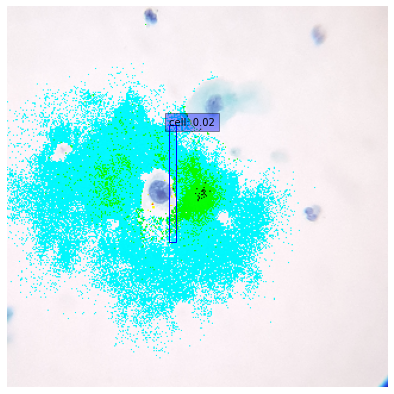

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[0.02082082]


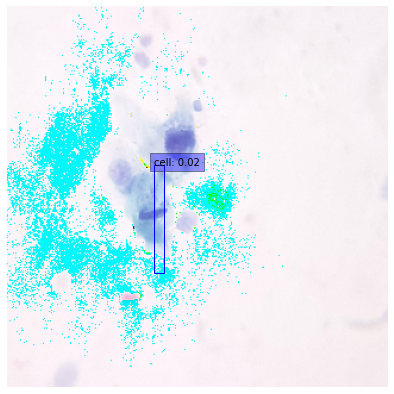

[]
[]
[]
[]
[]
[]
[]


In [50]:
for samples in val_dataset.take(50):
    images = samples[0]
    labels = samples[1]
    images = tf.keras.applications.resnet.preprocess_input(images)
    images = tf.cast(images, dtype=tf.float32)
#     images = tf.expand_dims(images, axis=0)
#     print(images.shape)
#     predictions = model(image, training=False)
#     print(type(predictions))
#     print((predictions))
    detections = inference_model.predict(images)
    num_detections = detections.valid_detections[0]
#     print(num_detections)
#     class_names = [
#         int2str(int(x)) for x in detections.nmsed_classes[0][:num_detections]
#     ]
    class_names = ['cell']*(num_detections)
#     print(detections.nmsed_boxes[0])
    images = tf.squeeze(images)
    print(detections.nmsed_scores[0][:num_detections])
    if num_detections > 0 :
        visualize_detections(
            images,
            detections.nmsed_boxes[0][:num_detections],
            class_names,
            detections.nmsed_scores[0][:num_detections],
        )

In [ ]:
class Data:
    def __init__(self):
        pass

    def back_to_zero(self, input):
        time = tf.slice(input, [0,0], [-1,1])
        new_time = time - time[0][0]
        return new_time

    @tf.function
    def load_data(self, inputs):
        new_x = self.back_to_zero(inputs)
        tf.print(new_x)

In [ ]:
time = np.linspace(0,10,20)
magntiudes = np.random.normal(0,1,size=20)
x = np.vstack([time, magntiudes]).T


d = Data()
d.load_data(x)

In [ ]:
backbone = keras.applications.MobileNetV2(include_top=False, input_shape=[None, None, 3])

In [ ]:
backbone.summary()